Iñigo Martin Melero

## Participante 26

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_26_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


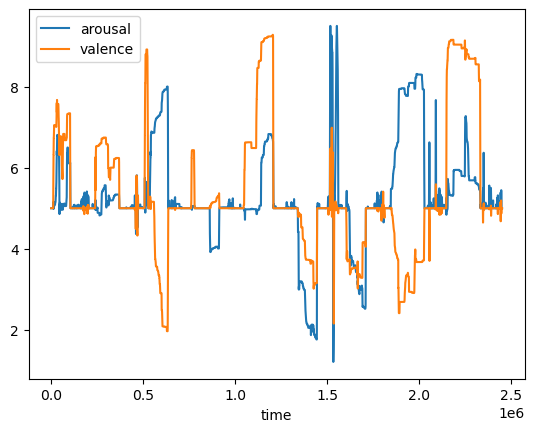

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_26_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.885  37.581  36.532  46.147  26.480     6.961     7.124   
1              1  0.882  37.630  36.563  46.118  26.476     6.838     7.124   
2              2  0.895  37.304  36.513  46.136  26.473     6.918     7.287   
3              3  0.889  37.406  36.524  46.117  26.473     6.837     7.085   
4              4  0.882  37.570  36.571  46.136  26.480     6.958     7.205   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.807  37.290  42.919  47.114  27.198     5.851     5.276   
2451580  2451580  0.816  37.435  42.927  47.133  27.202     5.810     5.316   
2451581  2451581  0.820  37.475  43.005  47.134  27.209     5.850     5.358   
2451582  2451582  0.813  37.216  42.904  47.191  27.205     5.891     5.236   
2451583  2451583  0.816  37.377  42.985  47.115  27.212     5.973     5.397   

         emg_trap  video  
0           7.330     10

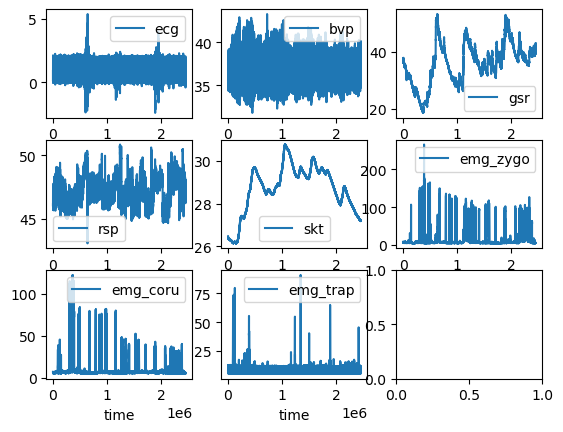

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

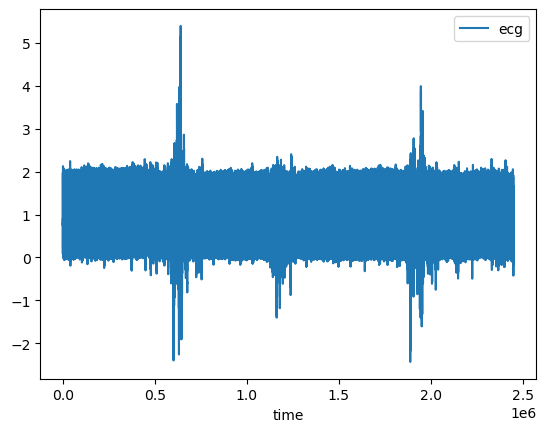

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

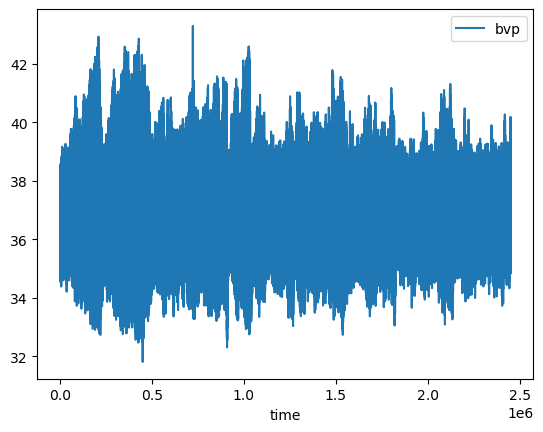

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

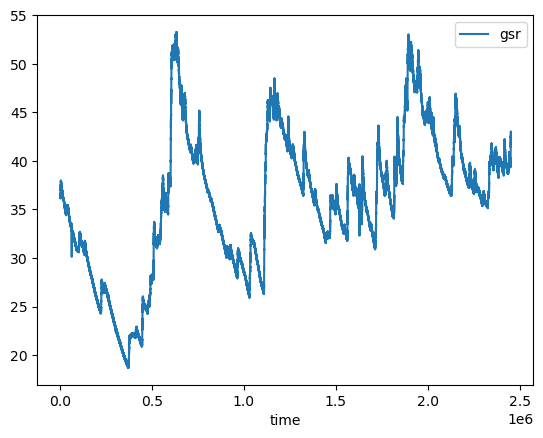

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

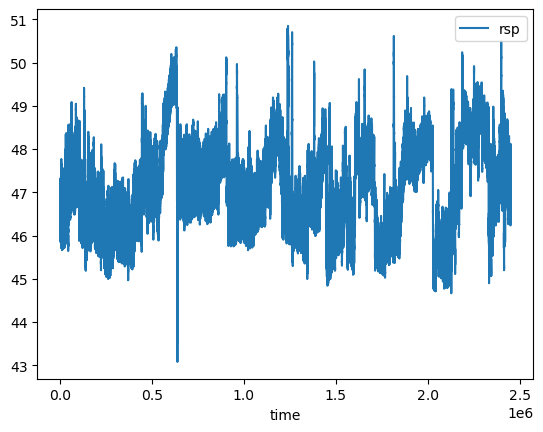

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

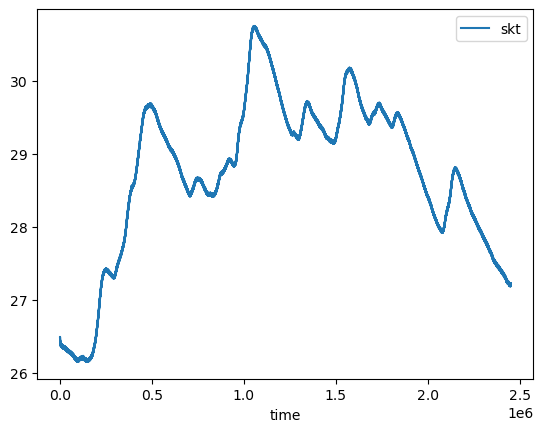

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

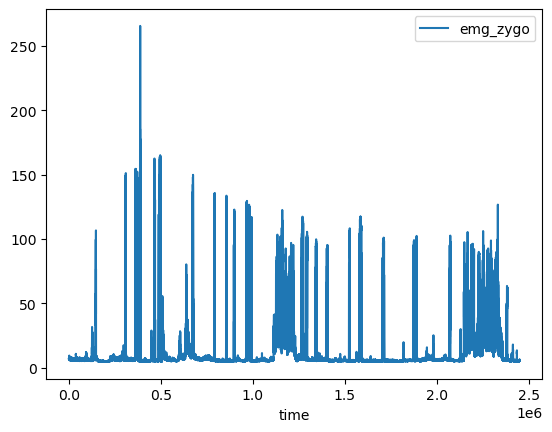

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

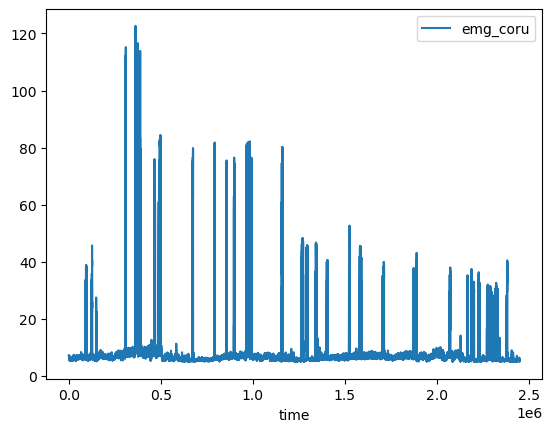

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

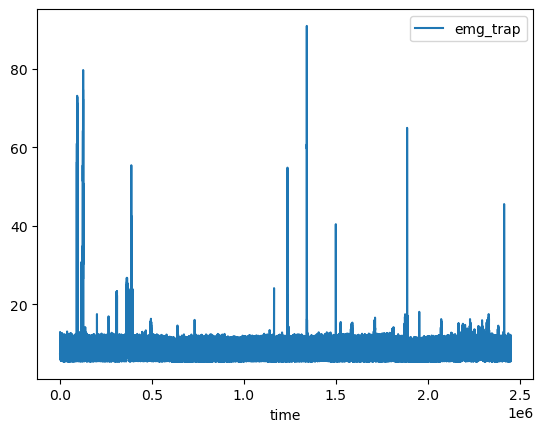

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

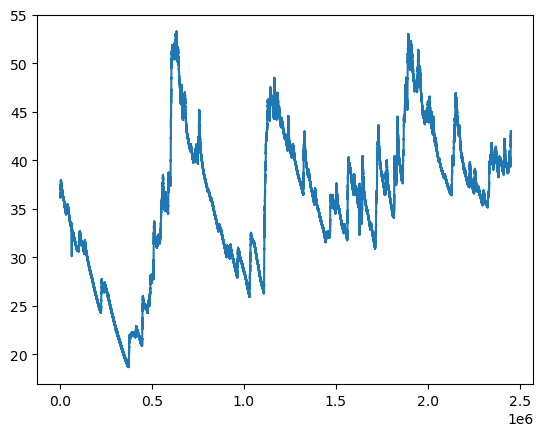

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

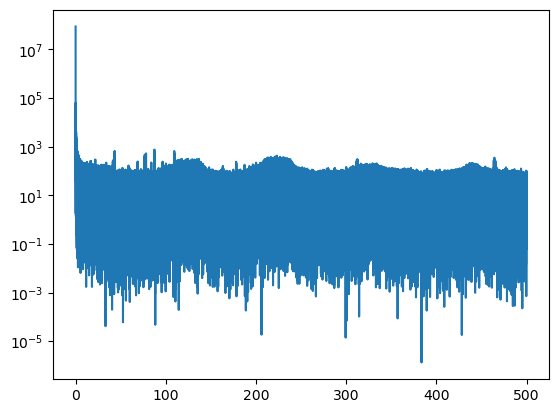

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

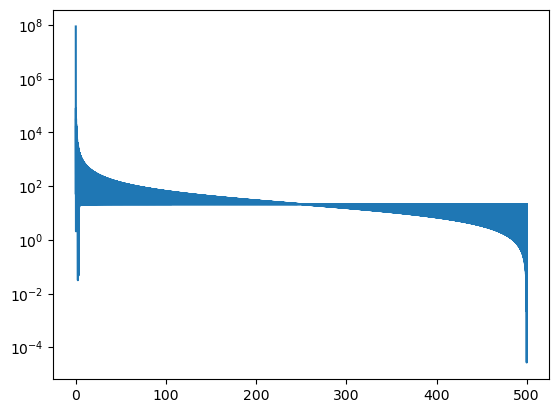

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

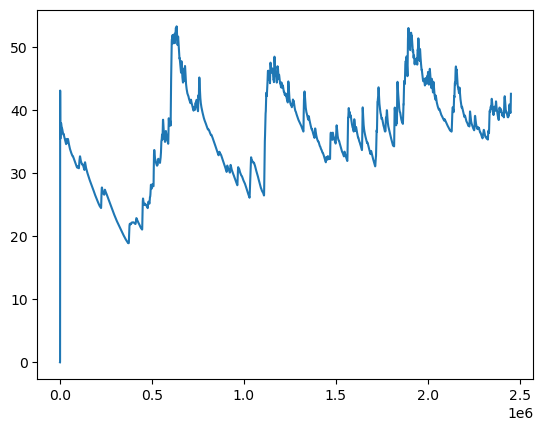

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  42.521
2451580  42.522
2451581  42.523
2451582  42.524
2451583  42.526

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

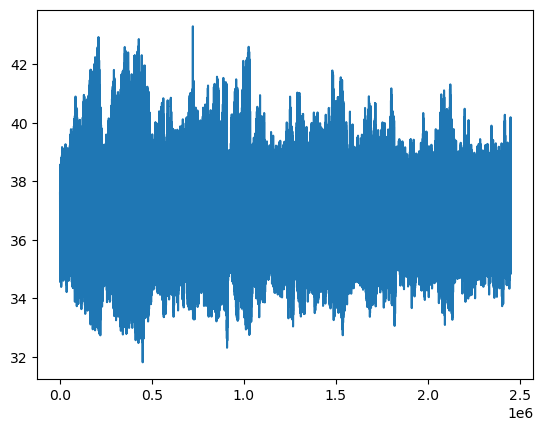

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

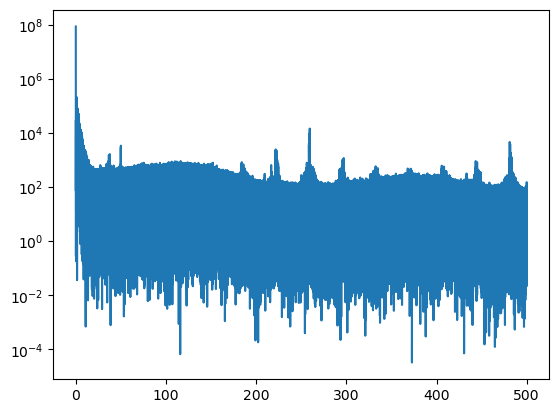

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

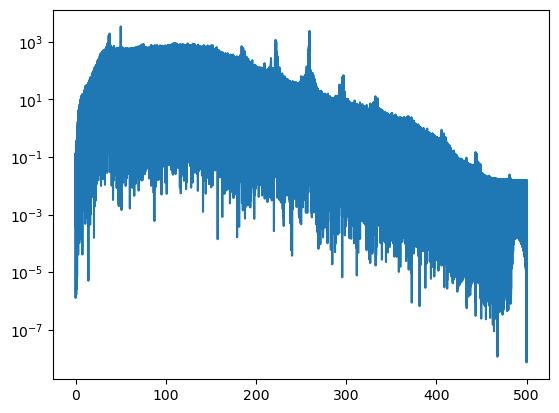

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

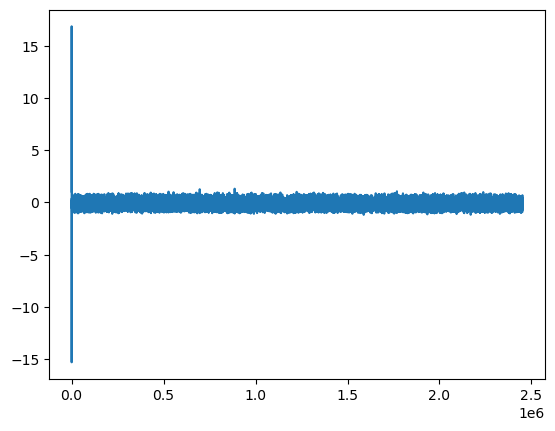

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.044
1        42.827
2        50.705
3        53.918
4        46.403
...         ...
2451579  37.014
2451580  37.025
2451581  36.992
2451582  37.000
2451583  37.026

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

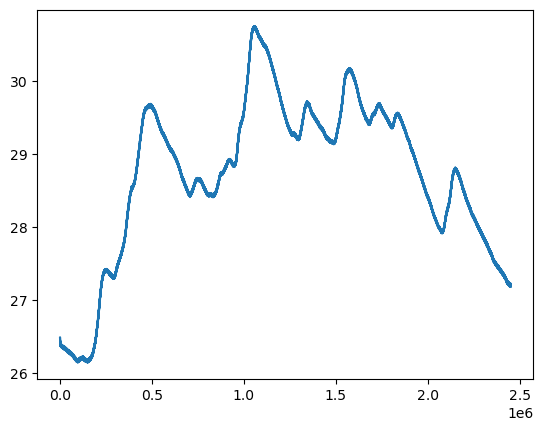

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

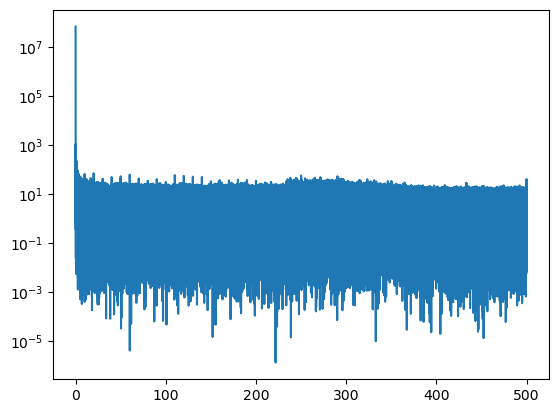

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

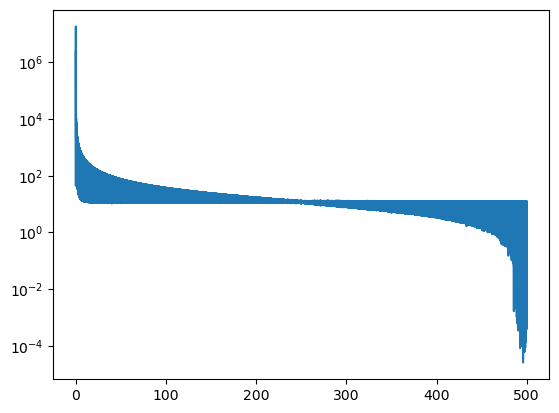

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

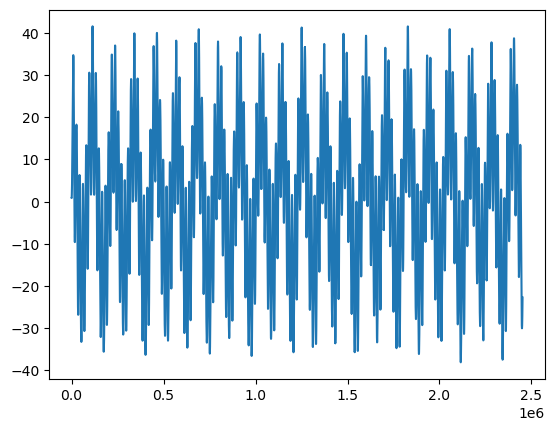

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.849
1        40.848
2        40.848
3        40.848
4        40.849
...         ...
2451579  17.167
2451580  17.171
2451581  17.176
2451582  17.180
2451583  17.184

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.885  46.147     6.961     7.124     7.330     10
1              1  0.882  46.118     6.838     7.124     7.289     10
2              2  0.895  46.136     6.918     7.287     7.369     10
3              3  0.889  46.117     6.837     7.085     7.289     10
4              4  0.882  46.136     6.958     7.205     7.369     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.807  47.114     5.851     5.276     6.385     12
2451580  2451580  0.816  47.133     5.810     5.316     6.303     12
2451581  2451581  0.820  47.134     5.850     5.358     6.425     12
2451582  2451582  0.813  47.191     5.891     5.236     6.466     12
2451583  2451583  0.816  47.115     5.973     5.397     6.426     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.885  46.147     6.961     7.124     7.330     10  38.044   
1              1  0.882  46.118     6.838     7.124     7.289     10  42.827   
2              2  0.895  46.136     6.918     7.287     7.369     10  50.705   
3              3  0.889  46.117     6.837     7.085     7.289     10  53.918   
4              4  0.882  46.136     6.958     7.205     7.369     10  46.403   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.807  47.114     5.851     5.276     6.385     12  37.014   
2451580  2451580  0.816  47.133     5.810     5.316     6.303     12  37.025   
2451581  2451581  0.820  47.134     5.850     5.358     6.425     12  36.992   
2451582  2451582  0.813  47.191     5.891     5.236     6.466     12  37.000   
2451583  2451583  0.816  47.115     5.973     5.397     6.426     12  37.026   

            gsr     skt  
0         0.000  40.849  
1         0.000  40.848  
2         0.000  40.848  
3         0.000  40.848  
4         0.000  40.849  
...         ...     ...  
2451579  42.521  17.167  
2451580  42.522  17.171  
2451581  42.523  17.176  
2451582  42.524  17.180  
2451583  42.526  17.184  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.491591  0.480096  0.163356  0.791355  0.396951  0.003836   
221502    221502  0.494083  0.459395  0.163356  0.791276  0.404291  0.004598   
221503    221503  0.495017  0.476115  0.163326  0.791198  0.395257  0.003592   
221504    221504  0.493616  0.508758  0.163326  0.791119  0.396951  0.004342   
221505    221505  0.492526  0.512739  0.163326  0.791040  0.397139  0.004348   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.551853  0.455812  0.513224  0.346554  0.262187  0.446078   
2331580  2331580  0.552320  0.474522  0.513224  0.346632  0.256917  0.449689   
2331581  2331581  0.552943  0.471736  0.513194  0.346711  0.256729  0.452013   
2331582  2331582  0.551386  0.460191  0.513194  0.346803  0.256729  0.454068   
2331583  2331583  0.554967  0.465366  0.513194  0.346881  0.267645  0.454343   

         emg_coru  emg_trap  video  
221501   0.008358  0.006222      6  
221502   0.009054  0.008113      6  
221503   0.007338  0.005288      6  
221504   0.007661  0.005732      6  
221505   0.007670  0.006689      6  
...           ...       ...    ...  
2331579  0.200182  0.069016      1  
2331580  0.200207  0.067604      1  
2331581  0.200207  0.066635      1  
2331582  0.201592  0.068526      1  
2331583  0.204369  0.069974      1  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.491591  0.480096  0.163356  0.396951  0.791355  0.003836   
221502    221502  0.494083  0.459395  0.163356  0.404291  0.791276  0.004598   
221503    221503  0.495017  0.476115  0.163326  0.395257  0.791198  0.003592   
221504    221504  0.493616  0.508758  0.163326  0.396951  0.791119  0.004342   
221505    221505  0.492526  0.512739  0.163326  0.397139  0.791040  0.004348   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.551853  0.455812  0.513224  0.262187  0.346554  0.446078   
2331580  2331580  0.552320  0.474522  0.513224  0.256917  0.346632  0.449689   
2331581  2331581  0.552943  0.471736  0.513194  0.256729  0.346711  0.452013   
2331582  2331582  0.551386  0.460191  0.513194  0.256729  0.346803  0.454068   
2331583  2331583  0.554967  0.465366  0.513194  0.267645  0.346881  0.454343   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.490034  0.495223  0.163326  0.393375  0.789900  0.003836  0.007330   
221540   0.488944  0.432723  0.163297  0.395257  0.788380  0.002817  0.008375   
221560   0.487387  0.453025  0.163268  0.393375  0.786859  0.002817  0.008723   
221580   0.488944  0.475717  0.163238  0.389799  0.785326  0.002049  0.008723   
221600   0.488944  0.440287  0.163209  0.389799  0.783805  0.002043  0.008714   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.531922  0.492436  0.513811  0.236778  0.339987  0.429205  0.086149   
2331520  0.538150  0.474522  0.513664  0.247694  0.341665  0.448871  0.182388   
2331540  0.548739  0.484076  0.513517  0.245812  0.343316  0.382058  0.202645   
2331560  0.548272  0.492038  0.513341  0.244118  0.344968  0.424007  0.180715   
2331580  0.552320  0.474522  0.513224  0.256917  0.346632  0.449689  0.200207   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.490034  0.495223  0.163326  0.393375  0.789900  0.003836  0.007330   
1      0.488944  0.432723  0.163297  0.395257  0.788380  0.002817  0.008375   
2      0.487387  0.453025  0.163268  0.393375  0.786859  0.002817  0.008723   
3      0.488944  0.475717  0.163238  0.389799  0.785326  0.002049  0.008723   
4      0.488944  0.440287  0.163209  0.389799  0.783805  0.002043  0.008714   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.531922  0.492436  0.513811  0.236778  0.339987  0.429205  0.086149   
63500  0.538150  0.474522  0.513664  0.247694  0.341665  0.448871  0.182388   
63501  0.548739  0.484076  0.513517  0.245812  0.343316  0.382058  0.202645   
63502  0.548272  0.492038  0.513341  0.244118  0.344968  0.424007  0.180715   
63503  0.552320  0.474522  0.513224  0.256917  0.346632  0.449689  0.200207   

       emg_trap  valence  arousal  
0      0.005732    5.000    5.000  
1      0.005265    5.000    5.000  
2      0.004786    5.000    5.000  
3      0.005265    5.000    5.000  
4      0.005732    5.000    5.000  
...         ...      ...      ...  
63499  0.083912    8.153    5.444  
63500  0.075250    8.154    5.444  
63501  0.073803    8.159    5.445  
63502  0.067604    8.166    5.445  
63503  0.067604    8.174    5.443  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.490034  0.495223  0.163326  0.393375  0.789900  0.003836  0.007330   
1      0.488944  0.432723  0.163297  0.395257  0.788380  0.002817  0.008375   
2      0.487387  0.453025  0.163268  0.393375  0.786859  0.002817  0.008723   
3      0.488944  0.475717  0.163238  0.389799  0.785326  0.002049  0.008723   
4      0.488944  0.440287  0.163209  0.389799  0.783805  0.002043  0.008714   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.610713  0.505175  0.514399  0.209486  0.333329  0.374868  0.197430   
63496  0.645126  0.430334  0.514252  0.225861  0.335007  0.337154  0.185582   
63497  0.431641  0.486863  0.514105  0.223979  0.336658  0.376130  0.208905   
63498  0.520243  0.498010  0.513958  0.222097  0.338323  0.326153  0.187722   
63499  0.531922  0.492436  0.513811  0.236778  0.339987  0.429205  0.086149   

       emg_trap  valence  arousal  
0      0.005732    5.000    5.000  
1      0.005265    5.000    5.000  
2      0.004786    5.000    5.000  
3      0.005265    5.000    5.000  
4      0.005732    5.000    5.000  
...         ...      ...      ...  
63495  0.072869    8.151    5.448  
63496  0.083877    8.153    5.448  
63497  0.104482    8.154    5.447  
63498  0.127059    8.153    5.445  
63499  0.083912    8.153    5.444  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.490034  0.495223  0.163326  0.393375  0.789900  0.003836  0.007330   
 1   0.488944  0.432723  0.163297  0.395257  0.788380  0.002817  0.008375   
 2   0.487387  0.453025  0.163268  0.393375  0.786859  0.002817  0.008723   
 3   0.488944  0.475717  0.163238  0.389799  0.785326  0.002049  0.008723   
 4   0.488944  0.440287  0.163209  0.389799  0.783805  0.002043  0.008714   
 5   0.487387  0.486067  0.163180  0.391681  0.782272  0.003586  0.007330   
 6   0.488944  0.488455  0.163180  0.389799  0.780738  0.003592  0.006642   
 7   0.497197  0.488854  0.163150  0.380764  0.779205  0.004354  0.006285   
 8   0.513547  0.460589  0.163121  0.377000  0.777658  0.003836  0.006625   
 9   0.509966  0.460191  0.163091  0.369848  0.776125  0.003323  0.006965   
 10  0.489567  0.476513  0.163062  0.367965  0.774578  0.003323  0.006633   
 11  0.479757  0.458599  0.163033  0.358743  0.773045  0.003580  0.006268   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.490034  0.495223  0.163326  0.393375  0.789900  0.003836  0.007330   
1     0.539084  0.451831  0.162504  0.247694  0.751314  0.004086  0.007313   
2     0.507319  0.458599  0.161828  0.074534  0.712492  0.006916  0.008026   
3     0.530987  0.456210  0.161328  0.112742  0.674745  0.006141  0.013938   
4     0.585643  0.474920  0.164179  0.360625  0.639173  0.005110  0.009759   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.493149  0.458201  0.520688  0.568229  0.155393  0.134168  0.006277   
2536  0.498754  0.500000  0.522069  0.664784  0.185499  0.137504  0.008018   
2537  0.492993  0.424363  0.521217  0.462639  0.220389  0.531738  0.191476   
2538  0.491124  0.487261  0.519630  0.233013  0.258988  0.278807  0.051606   
2539  0.496730  0.461783  0.516838  0.200264  0.299933  0.227418  0.086489   

             8         9        10  ...       193       194       195  \
0     0.005732  0.488944  0.432723  ...  0.527873  0.499204  0.162533   
1     0.011966  0.548739  0.469347  ...  0.506851  0.441879  0.161857   
2     0.004775  0.522734  0.479299  ...  0.548272  0.447452  0.161328   
3     0.008125  0.521644  0.486465  ...  0.499689  0.488057  0.163914   
4     0.006222  0.679851  0.500398  ...  0.498131  0.484076  0.173905   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.004308  0.492059  0.435510  ...  0.500156  0.516720  0.522039   
2536  0.005732  0.482404  0.556927  ...  0.479757  0.514729  0.521275   
2537  0.076196  0.488477  0.468551  ...  0.477733  0.498010  0.519718   
2538  0.023955  0.504827  0.499602  ...  0.503270  0.468153  0.516985   
2539  0.051295  0.511990  0.476115  ...  0.531922  0.492436  0.513811   

           196       197       198       199       200  valence  arousal  
0     0.267645  0.752874  0.004604  0.008018  0.014371  5.00000  5.00000  
1     0.070958  0.714039  0.007178  0.007670  0.005744  5.00000  5.00000  
2     0.105590  0.676226  0.006653  0.011509  0.007646  5.00000  5.00000  
3     0.353284  0.640536  0.004610  0.010795  0.005744  5.00000  5.00000  
4     0.562771  0.607927  0.013837  0.010804  0.007179  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.639375  0.184201  0.186263  0.008018  0.005744  8.14100  5.45900  
2536  0.471673  0.218921  0.433134  0.185573  0.073838  8.14100  5.45900  
2537  0.223979  0.257389  0.287765  0.048141  0.022542  8.14100  5.45900  
2538  0.207604  0.298269  0.420815  0.181428  0.074795  8.14096  5.45904  
2539  0.236778  0.339987  0.429205  0.086149  0.083912  8.14384  5.44896  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.490034  0.495223  0.163326  0.393375  0.789900  0.003836  0.007330   
1     0.539084  0.451831  0.162504  0.247694  0.751314  0.004086  0.007313   
2     0.507319  0.458599  0.161828  0.074534  0.712492  0.006916  0.008026   
3     0.530987  0.456210  0.161328  0.112742  0.674745  0.006141  0.013938   
4     0.585643  0.474920  0.164179  0.360625  0.639173  0.005110  0.009759   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.493149  0.458201  0.520688  0.568229  0.155393  0.134168  0.006277   
2536  0.498754  0.500000  0.522069  0.664784  0.185499  0.137504  0.008018   
2537  0.492993  0.424363  0.521217  0.462639  0.220389  0.531738  0.191476   
2538  0.491124  0.487261  0.519630  0.233013  0.258988  0.278807  0.051606   
2539  0.496730  0.461783  0.516838  0.200264  0.299933  0.227418  0.086489   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub26.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.490034  0.495223  0.163326  0.393375  0.789900  0.003836  0.007330   
1     0.539084  0.451831  0.162504  0.247694  0.751314  0.004086  0.007313   
2     0.507319  0.458599  0.161828  0.074534  0.712492  0.006916  0.008026   
3     0.530987  0.456210  0.161328  0.112742  0.674745  0.006141  0.013938   
4     0.585643  0.474920  0.164179  0.360625  0.639173  0.005110  0.009759   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.493149  0.458201  0.520688  0.568229  0.155393  0.134168  0.006277   
2536  0.498754  0.500000  0.522069  0.664784  0.185499  0.137504  0.008018   
2537  0.492993  0.424363  0.521217  0.462639  0.220389  0.531738  0.191476   
2538  0.491124  0.487261  0.519630  0.233013  0.258988  0.278807  0.051606   
2539  0.496730  0.461783  0.516838  0.200264  0.299933  0.227418  0.086489   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub26.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.490034  0.495223  0.163326  0.393375  0.789900  0.003836  0.007330   
1     0.539084  0.451831  0.162504  0.247694  0.751314  0.004086  0.007313   
2     0.507319  0.458599  0.161828  0.074534  0.712492  0.006916  0.008026   
3     0.530987  0.456210  0.161328  0.112742  0.674745  0.006141  0.013938   
4     0.585643  0.474920  0.164179  0.360625  0.639173  0.005110  0.009759   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.493149  0.458201  0.520688  0.568229  0.155393  0.134168  0.006277   
2536  0.498754  0.500000  0.522069  0.664784  0.185499  0.137504  0.008018   
2537  0.492993  0.424363  0.521217  0.462639  0.220389  0.531738  0.191476   
2538  0.491124  0.487261  0.519630  0.233013  0.258988  0.278807  0.051606   
2539  0.496730  0.461783  0.516838  0.200264  0.299933  0.227418  0.086489   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub26.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.490034  0.495223  0.163326  0.393375  0.789900  0.003836  0.007330   
1     0.539084  0.451831  0.162504  0.247694  0.751314  0.004086  0.007313   
2     0.507319  0.458599  0.161828  0.074534  0.712492  0.006916  0.008026   
3     0.530987  0.456210  0.161328  0.112742  0.674745  0.006141  0.013938   
4     0.585643  0.474920  0.164179  0.360625  0.639173  0.005110  0.009759   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.493149  0.458201  0.520688  0.568229  0.155393  0.134168  0.006277   
2536  0.498754  0.500000  0.522069  0.664784  0.185499  0.137504  0.008018   
2537  0.492993  0.424363  0.521217  0.462639  0.220389  0.531738  0.191476   
2538  0.491124  0.487261  0.519630  0.233013  0.258988  0.278807  0.051606   
2539  0.496730  0.461783  0.516838  0.200264  0.299933  0.227418  0.086489   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub26.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.490034  0.495223  0.163326  0.393375  0.789900  0.003836  0.007330   
1     0.539084  0.451831  0.162504  0.247694  0.751314  0.004086  0.007313   
2     0.507319  0.458599  0.161828  0.074534  0.712492  0.006916  0.008026   
3     0.530987  0.456210  0.161328  0.112742  0.674745  0.006141  0.013938   
4     0.585643  0.474920  0.164179  0.360625  0.639173  0.005110  0.009759   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.493149  0.458201  0.520688  0.568229  0.155393  0.134168  0.006277   
2536  0.498754  0.500000  0.522069  0.664784  0.185499  0.137504  0.008018   
2537  0.492993  0.424363  0.521217  0.462639  0.220389  0.531738  0.191476   
2538  0.491124  0.487261  0.519630  0.233013  0.258988  0.278807  0.051606   
2539  0.496730  0.461783  0.516838  0.200264  0.299933  0.227418  0.086489   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub26.csv', index=False)